In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import imageio
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

In [2]:
df = pd.read_csv("../data/full_df_cleaned_v3.csv")

In [3]:
df.head()

,Diagnostic,file,target_init,Patient Age,Patient Sex,Target,tarstr,N,D,G,C,A,H,M,O,filename
0,normal fundus,0_right.jpg,"[1, 0, 0, 0, 0, 0, 0, 0]",69,Female,"[1, 0, 0, 0, 0, 0, 0, 0]",N,1,0,0,0,0,0,0,0,0_right_69_Female_N.jpg
1,normal fundus,1_right.jpg,"[1, 0, 0, 0, 0, 0, 0, 0]",57,Male,"[1, 0, 0, 0, 0, 0, 0, 0]",N,1,0,0,0,0,0,0,0,1_right_57_Male_N.jpg
2,moderate non proliferative retinopathy,2_right.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]",42,Male,"[0, 1, 0, 0, 0, 0, 0, 0]",D,0,1,0,0,0,0,0,0,2_right_42_Male_D.jpg
3,mild nonproliferative retinopathy,4_right.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]",53,Male,"[0, 1, 0, 0, 0, 0, 0, 0]",D,0,1,0,0,0,0,0,0,4_right_53_Male_D.jpg
4,moderate non proliferative retinopathy,5_right.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]",50,Female,"[0, 1, 0, 0, 0, 0, 0, 0]",D,0,1,0,0,0,0,0,0,5_right_50_Female_D.jpg


### **New Dataframe avec uniquement les observations Normal & Cataract**

In [4]:
df_n = df[df['tarstr']=='N']

In [5]:
df_c = df[df['tarstr']=='C']

In [6]:
df_N_C = pd.concat([df_n, df_c], ignore_index=True)

**New Columns with the image PATH**

In [7]:
IMAGE_PATH = 'D:/College/6th_Semester/Mini_Project/data/preprocessed_images2/'

In [8]:
df_N_C['filepath'] = IMAGE_PATH + df_N_C['filename']

**Add every image to the img_data array**

In [14]:
import imageio.v2 as imageio

In [9]:
img_data = []
number_id_nofile = []

for i in range(len(df_N_C)):
  try:
    img_data.append(imageio.imread(df_N_C['filepath'][i]))
  except:
    number_id_nofile.append(df_N_C.index[i])

C:\Users\Hamza\AppData\Local\Temp\ipykernel_15156\3197145038.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_data.append(imageio.imread(df_N_C['filepath'][i]))


In [ ]:
img_data

In [31]:
img_data[0].shape

(256, 256, 3)

In [10]:
img_data_array = np.array(img_data)

**Create our X and y**

In [11]:
X = img_data_array

In [12]:
y = df_N_C['C']

In [13]:
y.value_counts()

C
0    2786
1     260
Name: count, dtype: int64

In [14]:
X.shape

(3046, 256, 256, 3)

**Train Test Split (en stratifiant sur y)**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)

**Normalize our images**

In [16]:
X_train = X_train / 255
X_test = X_test / 255

**Baseline model**

In [3]:
def initialize_model():
  model = models.Sequential()

  model.add(layers.Conv2D(32, (3,3), input_shape=(256, 256, 3), activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2,2)))
  model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(3,3)))
  model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(3,3)))
  ### Flattening
  model.add(layers.Flatten())
  ### One fully connected
  model.add(layers.Dense(120, activation='relu'))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(60, activation='relu'))
  model.add(layers.Dropout(rate=0.5))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', 
        optimizer='adam',
        metrics=['accuracy'])

  return model

In [4]:
model = initialize_model()
model.summary()

c:\Users\Hamza\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     1,505,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,901,137 (7.25 MB)

 Trainable params: 1,901,137 (7.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = initialize_model()
es = EarlyStopping(patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=1,
                    batch_size=16, 
                    verbose=1,
                    callbacks=[es])

: 

**Evaluate on X_test & y_test**

In [88]:
model.evaluate(X_test, y_test, verbose=0)

[0.12054170668125153, 0.9551422595977783]

**Save the Baseline model**

In [92]:
model.save("new_model_4.h5")

In [93]:
from tensorflow.keras.models import load_model

model = load_model("new_model_4.h5")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │     1,505,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 60)             │         7,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,901,139 (7.25 MB)

 Trainable params: 1,901,137 (7.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [97]:
import numpy as np
import imageio.v2 as imageio
testfile_path = "../data/Train_test_split/Test/0_left_69_Female_C.jpg"
img_data = imageio.imread(testfile_path)
img_data_normalized = img_data / 255.0
img_data_batch = np.expand_dims(img_data_normalized, axis=0)
prediction = model.predict(img_data_batch)
class_labels = ['Normal', 'Cataract']
print("Prediction probability:", prediction)
predicted_class = class_labels[int(prediction > 0.5)]
print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Prediction probability: [[0.681278]]
Predicted class: Cataract


C:\Users\danis\AppData\Local\Temp\ipykernel_21792\2124600481.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = class_labels[int(prediction > 0.5)]


# Model Architecture

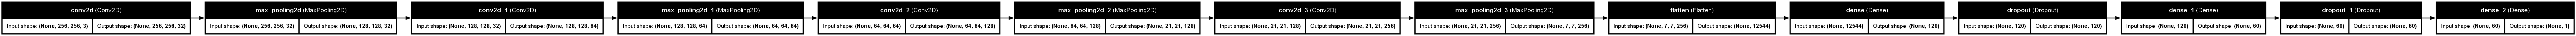

In [27]:
from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
# plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=True, dpi=96)

plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=True, dpi=96)

In [26]:
from keras.utils import plot_model
from graphviz import Digraph

def plot_model_multi_line(model, nodes_per_line, to_file='model_architecture.png'):
    dot = Digraph()

    # Create nodes for each layer
    for i, layer in enumerate(model.layers):
        dot.node(str(i), label=layer.name)

    # Connect layers with edges
    for i, layer in enumerate(model.layers):
        if i > 0:
            dot.edge(str(i - 1), str(i))

    # Define positions for nodes in multiple lines
    pos = {}
    x_offset = 0
    y_offset = 0
    for i, layer in enumerate(model.layers):
        pos[str(i)] = '"' + str(x_offset) + ',' + str(y_offset) + '!"'
        x_offset += 1
        if x_offset == nodes_per_line:
            x_offset += 1
            y_offset += 1  # Move to the next line

    # Set graph attributes
    dot.attr(rankdir='LR', splines='ortho', nodesep='0.2', ranksep='0.5')
    dot.attr('node', shape='rectangle', style='filled', fillcolor='lightblue')

    # Apply positions to nodes
    for node, position in pos.items():
        dot.node(node, pos=position)

    # Render the graph to a file
    dot.render(to_file, format='png', cleanup=True)

# Usage
plot_model_multi_line(model, nodes_per_line=4, to_file='model_architecture')